In [2]:
!git clone https://github.com/Praneet9/Sentiment_Analysis

Cloning into 'Sentiment_Analysis'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 1), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [1]:
cd Sentiment_Analysis/

/content/Sentiment_Analysis


In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM, CuDNNLSTM
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [0]:
EPOCHS = 50
BATCH_SIZE = 64
NAME = 'LSTM-EPOCHS-50'

In [0]:
lemmatizer = WordNetLemmatizer()

In [6]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [7]:
train.shape

(156060, 4)

In [8]:
test.shape

(66292, 3)

In [9]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [0]:
def clean_sentences(df):
    reviews = []
    
    for sent in tqdm(df['Phrase']):
        
        # removing html content if any
        review_text = BeautifulSoup(sent).get_text()
        
        # removing non alphabetic characters
        review_text = re.sub("[^A-Za-z]", " ", review_text)
        
        # tokenizing the sentences
        words = word_tokenize(review_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
        
    return reviews

In [11]:
# clean reviews for both train and test set
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 66292/66292 [00:36<00:00, 1814.48it/s]

156060
66292


In [0]:
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sentences, y_target, test_size=0.2, stratify=y_target)

In [14]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if len(sent) > len_max:
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 463130.84it/s]

13737
48


In [0]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [16]:
# padding the the sentences with smaller length than max_length
# lstm needs sentences with equal sizes
# will be padded with zeros in the end

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape, X_val.shape, X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [17]:
model = Sequential()

model.add(Embedding(len(list(unique_words)), 500, input_length=len_max))

model.add(CuDNNLSTM(512, return_sequences=True))
model.add(Dropout(0.5))

model.add(CuDNNLSTM(256, return_sequences=True))
model.add(Dropout(0.4))

model.add(CuDNNLSTM(64, return_sequences=False))
model.add(Dropout(0.4))

model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dropout(0.3))

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = 'logs/' + NAME)

filepath = 'LSTM_Final'
checkpoint = ModelCheckpoint('models/{}.model'.format(filepath, monitor='val_acc',
                                                      verbose=1,
                                                      save_best_only = True,
                                                      mode = 'max'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 500)           6868500   
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 48, 512)           2076672   
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 512)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 48, 256)           788480    
_________________________________________________________________
dropout_2 (Dropout)          (None, 48, 256)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 64)                82432     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

In [18]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1, callbacks = [tensorboard, checkpoint])

Train on 124848 samples, validate on 31212 samples
Epoch 1/50
124848/124848 [==============================] - 166s 1ms/step - loss: 7.6431 - acc: 0.4991 - val_loss: 1.8146 - val_acc: 0.5099
Epoch 2/50
124848/124848 [==============================] - 164s 1ms/step - loss: 1.3548 - acc: 0.5113 - val_loss: 1.2028 - val_acc: 0.5099
Epoch 3/50
124848/124848 [==============================] - 164s 1ms/step - loss: 1.1789 - acc: 0.5481 - val_loss: 1.1750 - val_acc: 0.5535
Epoch 4/50
124848/124848 [==============================] - 164s 1ms/step - loss: 1.1473 - acc: 0.5682 - val_loss: 1.1631 - val_acc: 0.5549
Epoch 5/50
124848/124848 [==============================] - 164s 1ms/step - loss: 1.1276 - acc: 0.5721 - val_loss: 1.1551 - val_acc: 0.5538
Epoch 6/50
124848/124848 [==============================] - 164s 1ms/step - loss: 1.1136 - acc: 0.5768 - val_loss: 1.1458 - val_acc: 0.5556
Epoch 7/50
124848/124848 [==============================] - 164s 1ms/step - loss: 1.0980 - acc: 0.5792 - val_

In [0]:
import matplotlib.pyplot as plt

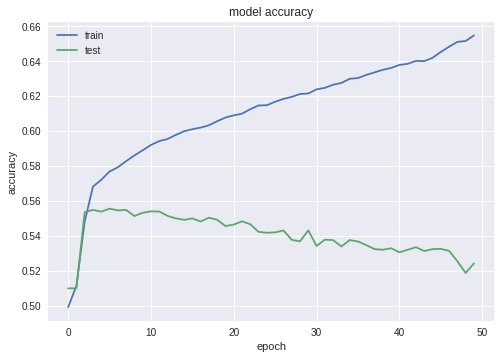

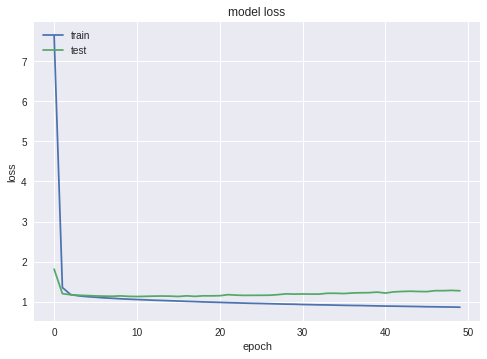

In [20]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import numpy as np 
import pandas as pd 
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
import re
from keras.utils import to_categorical
import random
from tensorflow import set_random_seed
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense,Dropout,Embedding,LSTM, CuDNNLSTM, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential
from tqdm import tqdm
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import regularizers

Using TensorFlow backend.


In [0]:
EPOCHS = 50
BATCH_SIZE = 16
NAME = 'LSTM2-EPOCHS-50'

In [0]:
lemmatizer = WordNetLemmatizer()

In [107]:
train = pd.read_csv('train.tsv', sep='\t')
test = pd.read_csv('test.tsv', sep='\t')

train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
train.drop_duplicates(subset='SentenceId', inplace = True)

In [0]:
test.drop_duplicates(subset='SentenceId', inplace = True)

In [110]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
63,64,2,"This quiet , introspective and entertaining in...",4
81,82,3,"Even fans of Ismail Merchant 's work , I suspe...",1
116,117,4,A positively thrilling combination of ethnogra...,3
156,157,5,Aggressive self-glorification and a manipulati...,1


In [111]:
train.shape

(8529, 4)

In [112]:
test.shape

(3310, 3)

In [113]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
15,156076,8546,Kidman is really the only thing that 's worth ...
93,156154,8547,Once you get into its rhythm ... the movie bec...
117,156178,8548,I kept wishing I was watching a documentary ab...
158,156219,8549,"Kinnear does n't aim for our sympathy , but ra..."


In [0]:
def clean_sentences(df):
    reviews = []
    
    for sent in tqdm(df['Phrase']):
        
        # removing html content if any
        review_text = BeautifulSoup(sent).get_text()
        
        # removing non alphabetic characters
        review_text = re.sub("[^A-Za-z]", " ", review_text)
        
        # tokenizing the sentences
        words = word_tokenize(review_text.lower())
        
        # lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
        
        reviews.append(lemma_words)
        
    return reviews

In [115]:
# clean reviews for both train and test set
train_sentences = clean_sentences(train)
test_sentences = clean_sentences(test)

print(len(train_sentences))
print(len(test_sentences))

100%|██████████| 3310/3310 [00:02<00:00, 1459.70it/s]

8529
3310


In [0]:
target = train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

In [0]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sentences, y_target, test_size=0.2, stratify=y_target)

In [118]:
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if len(sent) > len_max:
        len_max = len(sent)
        
print(len(list(unique_words)))
print(len_max)

100%|██████████| 6823/6823 [00:00<00:00, 332857.26it/s]

12352
48


In [0]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

In [120]:
# padding the the sentences with smaller length than max_length
# lstm needs sentences with equal sizes
# will be padded with zeros in the end

X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape, X_val.shape, X_test.shape)

(6823, 48) (1706, 48) (3310, 48)


In [0]:
from keras.datasets import imdb

(x_traina, y_traina), (x_testa, y_testa) = imdb.load_data()

In [5]:
x_traina.shape

(25000,)

In [0]:
max_words = 500
x_traina = sequence.pad_sequences(x_traina, maxlen=max_words)
x_testa = sequence.pad_sequences(x_testa, maxlen=max_words)

In [7]:
model = Sequential()

model.add(Embedding(500, 300, input_length=max_words))

model.add(CuDNNLSTM(32, return_sequences=True))
model.add(Dropout(0.7))
# model.add(BatchNormalization())

model.add(CuDNNLSTM(16, return_sequences=True))
model.add(Dropout(0.7))
# model.add(BatchNormalization())

model.add(CuDNNLSTM(8))
model.add(Dropout(0.8))
# model.add(BatchNormalization())

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='sparse_categorical_crossentropy', optimizer = Adam(lr=0.0001, decay=1e-6), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir = NAME)

filepath = 'LSTM2_Final'
checkpoint = ModelCheckpoint('{}.model'.format(filepath, monitor='val_acc',
                                                      verbose=1,
                                                      save_best_only = True,
                                                      mode = 'max'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 300)          150000    
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 500, 32)           42752     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 500, 16)           3200      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500, 16)           0         
_________________________________________________________________
cu_dnnlstm_3 (CuDNNLSTM)     (None, 8)                 832       
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
__________

In [8]:
history = model.fit(x_traina, y_traina, validation_data=(x_testa, y_testa), epochs=EPOCHS, batch_size = BATCH_SIZE, verbose=1, callbacks = [tensorboard, checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/50


InternalError: ignored